In [4]:
import matplotlib.pyplot as plt

%matplotlib widget

In [5]:
"""
A collection of functions to perform a dark photon search on an averaged spectrum


Functions
-------
median_filt(
    
):
    LPF for spectrum. Recomended as a pre-filter if
    spec contains large, very narrow candidates

butter_filt(

):
    LPF for spectrum. 

SG_filt(

):
    LPF for spectrum

match_filt(
    
):
    Performs a matched filtering on approx. normally distributed data
    Internal helper functions include freq2idx and genNuSteps

set_limit(

):
    Sets a limit (or series of limits) on an array of 
    normally distributed data (or list of arrays of normal data)

get_required_sigma(

):
    Given a number of samples and a desired confidence limit, tells you how 
    many "N" sigma you need to go to in order to be CL% confident no samples
    are above the calculated "N" 
"""
import numpy as np 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve


def median_filt(spec, filter_size=50):
    """
    Function to apply median filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    filter_size : int, optional
        Size of the median filter. Default is 50.

    Returns
    -------
    spectrum_filtered : array
        The median-filtered spectrum.
    """
    spectrum_gpu = cp.array(spec)
    spectrum_filtered_gpu = cpim.median_filter(
        spectrum_gpu,
        size=(filter_size),
        origin=0
    )
    spectrum_filtered = spectrum_filtered_gpu.get()
    return spectrum_filtered

def butter_filt(spec, cutoff=40000, order=6):
    """
    Function to apply Butterworth low-pass filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    cutoff : int, optional
        Cutoff frequency for the filter. Default is 40000.

    order : int, optional
        Order of the filter. Default is 6.

    Returns
    -------
    spectrum_filtered : array
        The Butterworth low-pass filtered spectrum.
    """
    nyq = 0.5 * len(spectrum)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    spectrum_filtered = filtfilt(b, a, spectrum)
    return spectrum_filtered

def sg_filt(window_length=51, polyorder=1):
    """
    Apply a Savitzky-Golay filter to the spectrum.

    Parameters
    ----------
    window_length : int, optional
        Length of the filter window; must be a positive odd integer, default is 51.
    polyorder : int, optional
        Order of the polynomial used to fit the samples, default is 1.

    Returns
    -------
    arr
        Filtered spectrum.
    """
    spectrum_filtered = spsig.savgol_filter(spec, window_length=window_length, polyorder=polyorder)
    return spectrum_filtered

def matched_filt(freqs, 
    spec, 
    startFreq, 
    stopFreq, 
    percent, 
    overlap
    ):
    """
    Apply a matched filter to the input spectrum over a specified frequency range.

    This function divides the freqs range into steps and applies a convolution
    operation with a lambda template for each step. The function returns the 
    convolved output for each freqs segment.

    Parameters
    ----------
    freqs : array-like
        Array of frequencies corresponding to the input spectrum.
    spec : array-like
        Array of spectral values to be filtered.
    startFreq : float
        Starting freqs of the range over which the filter is applied.
    stopFreq : float
        Stopping frequency of the range over which the filter is applied.
    percent : float
        Percentage to determine the step size between successive frequencies in the
        range (startFreq to stopFreq).
    overlap : int
        Number of overlapping elements between successive frequency segments.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - outputFreqs: List of arrays with the frequencies corresponding to each segment.
        - outputConv: List of arrays with the convolved values for each segment.

    Notes
    -----
    Frequency step generation (`gen_nu_steps`) is
    defined internally within this function.
    """
    def gen_nu_steps(freqs, startFreq, stopFreq, percent):
        freq    = startFreq
        nuStepList  = []
        while freq < stopFreq:
            #if freq > freqs:
            #    nu0Arr.append(400)
            nuStepList.append(freq)
            endFreq = freq + freq*percent/100
            freq = endFreq
        nuStepList.append(stopFreq) 
        return nuStepList
            
    nuStepList  = gen_nu_steps(freqs, startFreq, stopFreq, percent)
    outputConv  = []
    outputFreqs = []
    #change template over frequency range
    for i, nu in enumerate(nuStepList[0:-1]):
        idxStart        = freq2idx(nuStepList[i], freqs) - overlap
        nu0             = nuStepList[i] + (nuStepList[i+1] - nuStepList[i])/2
        if nuStepList[i+1] == stopFreq:
            idxStop     = freq2idx(nuStepList[i+1], freqs) - 10
        else:
            idxStop     = freq2idx(nuStepList[i+1], freqs) + overlap
        lamOut      = lam(freqs, nu0, p0=1, nBins=100)
        subConv     = np.convolve(np.flip(lamOut[1]), spec[idxStart:idxStop], mode='same')[overlap:-overlap]
        subFreqs    = freqs[idxStart+overlap:idxStop-overlap]
        
        outputConv.append(subConv)
        outputFreqs.append(subFreqs)
    return (outputFreqs, outputConv)

def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    # Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    # velocity args in km/s
    # vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    # output is normilized to p0
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 

def get_required_sigma(nBins, desired_confidence):    
    """
    Calculate the required standard deviation (sigma) level to achieve a specified
    confidence level that none of the samples in a given number of bins will exceed
    that sigma level.

    The function solves for the sigma level using the cumulative distribution function
    of the normal distribution and the binomial probability for the given number of bins.

    Parameters
    ----------
    nBins : int
        The number of bins or samples drawn from a normal distribution.
    desired_confidence : float
        The desired confidence level (between 0 and 1) for the probability that none
        of the samples will exceed the calculated sigma level. eg 0.95

    Returns
    -------
    float
        The calculated sigma level required to achieve the desired confidence.

    Notes
    -----
    The function uses the `fsolve` method from SciPy's optimize module to solve for
    the sigma value. If the solver does not converge, it returns a guessed value
    based on the inverse error function.
    """

    desired_confidence = 1-desired_confidence
    def probability_greater_than(sigma):
        return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

    def binomial(N, num_successes, prob_of_success):
        return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

    def probability_none_above(nBins, sigma):
        # returns probability that after nBins of draws from a normal distribution
        # that none of the draws will be above the sigma upper limit (mean+sigma)
        return 1-binomial(nBins, nBins, 1-probability_greater_than(sigma))

    guess     = scipy.special.erfinv(1-(2*(desired_confidence)/nBins))*np.sqrt(2) #from taylor expantion
    print(guess)
    nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(nBins, sigma)-desired_confidence, guess, full_output=True)
    nSig = nSig[0]
    if itr != 1:
        print('fSolve in get_required_sigma failed. Using guess')
        print(msg)
        nSig = guess
    
    return nSig

def set_lim(freqs, spec, CL):
    """
    Calculate the frequency limits and standard deviations for the given spectra.

    This function computes the limits by applying the required sigma to each segment
    of the input spectra and then concatenates the results to form the complete limit.
    It also flattens and concatenates the input frequency and spectrum arrays to match
    the shape of the limit.

    Parameters
    ----------
    freqs : arr or list of arr
        Array(s) of frequencies corresponding to the input spectra. If a single array
        is provided, it is wrapped in a list to form an array of arrays.
    spec : arr or list of arr
        Array(s) of spectra to calculate the limits for. If a single array is provided,
        it is wrapped in a list to form an array of arrays.
    CL : float
        Confidence level for calculating the required sigma. This value is used to
        determine how many standard deviations to apply to the spectra.

    Returns
    -------
    tuple
        A tuple containing three arrays: the concatenated frequency array, the
        concatenated spectrum array, and the calculated limit array.
    """
    # If the inputs are 1-D arrays, wrap them in a list to make them an array of arrays
    if isinstance(spec, (np.ndarray, list)) and not isinstance(spec[0], (np.ndarray, list)):
        freqs   = [freqs]
        spec    = [spec]
    nSamps = len(np.hstack(freqs))
    nSig = get_required_sigma(nSamps, CL)

    limits = []
    for idx in range(len(spec)):
        limits.append(nSig * 1.4826 * scipy.stats.median_abs_deviation(spec[idx]))

    limit   = np.concatenate([np.repeat(limit, len(freqs)) for limit, freqs in zip(limits, freqs)])
    freqs   = np.hstack(freqs)
    spec    = np.hstack(spec)

    return (freqs, spec, limit)

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))


NameError: name 'frequency' is not defined

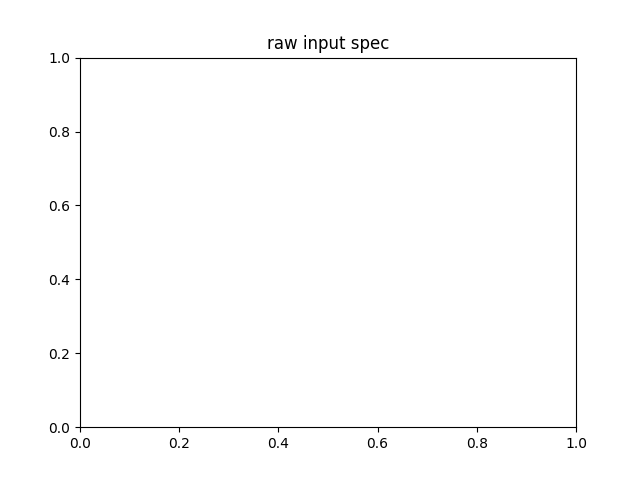

In [6]:
#test data
freqs       = np.linspace(0,400,2**23)
nu0         = 79.72012
p0          = 22
lamOut      = lam(freqs, nu0, p0, nBins=None, offset=-0e-6)
lamArr      = lamOut[1]

#normal noise
spec = np.random.normal(0,1,len(freqs)) + lamArr

spectrum = np.load('/drBiggerBoy/run1p4/plottingSpec/chB_avg_W_switch0.npy')[1:]
spectrum[2**22:2**22+10] *= 1
freqs = np.linspace(0,400,2**23)

freqStart       = 45
freqStop        = 301
idxStart        = freq2idx(freqStart, freqs)
idxStop         = freq2idx(freqStop, freqs)

#test data
testDataFlag = 0
if testDataFlag:
    if 0:
        np.random.seed(0)  # for reproducibility
        frequency = np.linspace(0, 400, 2**23)  # frequency range

        freqStart       = .5
        freqStop        = 9.5
        idxStart        = freq2idx(freqStart, frequency)
        idxStop         = freq2idx(freqStop, frequency)

        undulation = 10*np.sin(frequency * 100) + frequency*10 +100 # sinusoidal signal
        noise = np.random.normal(10, .01, frequency.shape)  # Gaussian noise
        noise[2**20:2**20+6] = 11.2
        spectrum = (undulation * noise)  # noisy spectrum

    if 0:
        #chirp    
        np.random.seed(0)  # for reproducibility
        frequency = np.linspace(0, 400, 2**23)  # frequency range
        undulation = spsig.chirp(frequency, 1/800, frequency[idxStop], 1/.1) + 100
        noise = np.random.normal(10, .01, frequency.shape)  # Gaussian noise
        noise[2**20:2**20+10] = 10.05
        spectrum = (undulation * noise)  # noisy spectrum


plt.close('all')


plt.figure()
plt.title('raw input spec')
plt.plot(frequency, spectrum)
plt.show()



startFreq   = 45
stopFreq    = 305
percent     = 10
overlap     = 100 #bins


In [34]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import shapiro 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve

%matplotlib widget

sys.path.insert(0, '../../../drlib')
import drlib as dr

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


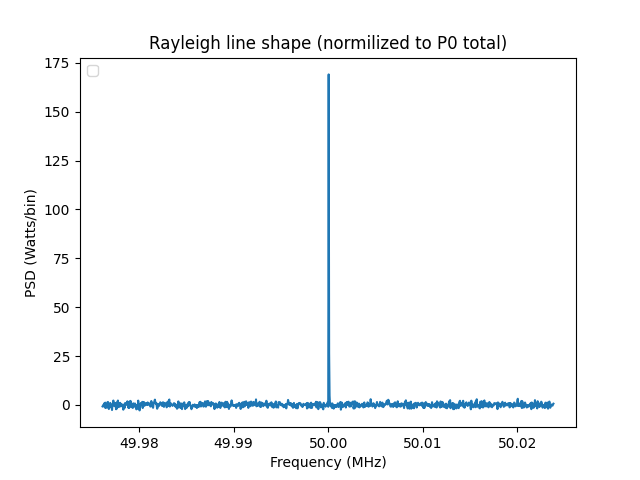

In [8]:
def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    # Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    # velocity args in km/s
    # vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    # output is normilized to p0
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 


 # normal values
nu0             = 50
freqs           = np.linspace(0, 400, 2**23)
nBins           = 1000

p0              = 200
lamOut          = lam(freqs, nu0, p0, nBins=nBins, offset=12e-6)
freqs           = lamOut[0]
lamArr          = lamOut[1]

noise           = np.random.normal(0, 1, nBins)
spec            = lamArr+noise
plt.close('all')
plt.figure()
plt.title('Rayleigh line shape (normilized to P0 total)')

plt.plot(freqs, spec)
#plt.scatter(freqs, lamArr)
plt.xlabel('Frequency (MHz)')
plt.ylabel('PSD (Watts/bin)')
plt.legend(loc = 'upper left')

SNR spec     : 245.31790754981148
SNR conv     : 216.23037429342727
SNR corr     : 235.23118595585447

STD spec     : 1.0204585275288085
STD conv     : 0.7233742883139831
STD corr     : 0.7212020237922222


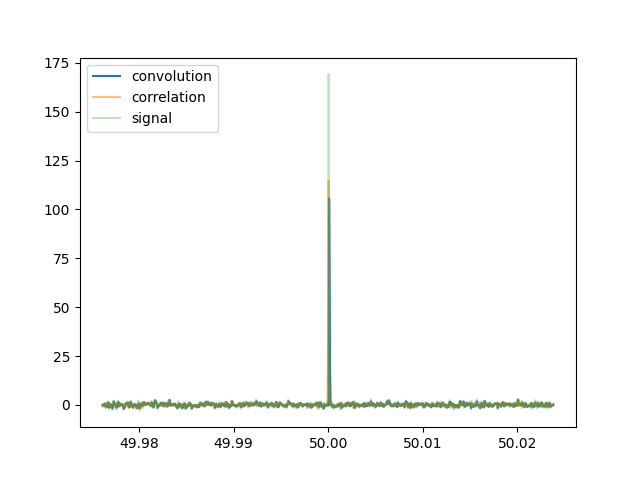

In [9]:
# show correlation is better than convolution

lamOut = lam(freqs, nu0, p0 = 1, nBins=nBins)[1]

corr        = np.correlate(spec, lamOut, mode='same')
conv        = np.convolve(spec, lamOut, mode='same')


print(f"SNR spec     : {spec.max()/scipy.stats.median_abs_deviation(spec)}")
print(f"SNR conv     : {conv.max()/scipy.stats.median_abs_deviation(conv)}")
print(f"SNR corr     : {corr.max()/scipy.stats.median_abs_deviation(corr)}")
print()
print(f"STD spec     : {1.48*scipy.stats.median_abs_deviation(spec)}")
print(f"STD conv     : {1.48*scipy.stats.median_abs_deviation(conv)}")
print(f"STD corr     : {1.48*scipy.stats.median_abs_deviation(corr)}")

plt.close('all')
plt.figure()
plt.plot(freqs, conv, label = 'convolution')
plt.plot(freqs, corr, label = 'correlation', alpha = 0.5)
plt.plot(freqs, spec, label = 'signal', alpha = .3)
#plt.plot(freqs, lamOut, '--', label = 'template')
plt.legend(loc='upper left')
plt.show()

SNR spec        : 245.31790754981148
SNR corr        : 235.23118595585447
SNR auto corr   : 96.53465912472122
SNR auto corr 2 : 41.86591012251328

STD spec     : 1.0204585275288085
STD corr     : 0.7233742883139831
STD auto corr: 232.37040093157935


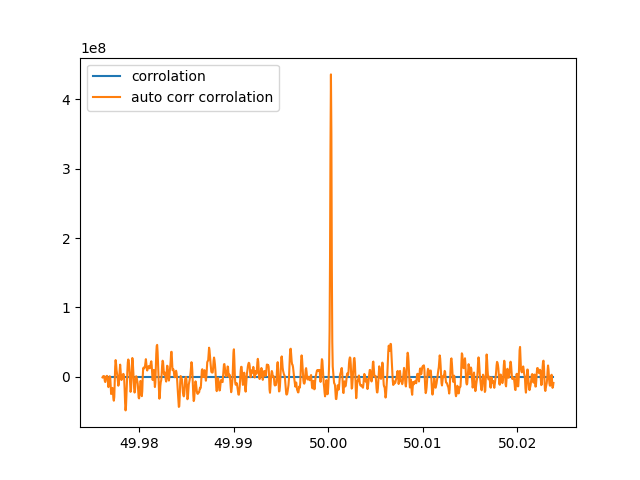

In [10]:
corr2 = np.convolve(corr, corr, mode = 'same')
corr3 = np.convolve(corr2, corr2, mode = 'same')

print(f"SNR spec        : {spec.max()/scipy.stats.median_abs_deviation(spec)}")
print(f"SNR corr        : {corr.max()/scipy.stats.median_abs_deviation(corr)}")
print(f"SNR auto corr   : {corr2.max()/scipy.stats.median_abs_deviation(corr2)}")
print(f"SNR auto corr 2 : {corr3.max()/scipy.stats.median_abs_deviation(corr3)}")
print()
print(f"STD spec     : {1.48*scipy.stats.median_abs_deviation(spec)}")
print(f"STD corr     : {1.48*scipy.stats.median_abs_deviation(conv)}")
print(f"STD auto corr: {1.48*scipy.stats.median_abs_deviation(corr2)}")


plt.close('all')
plt.figure()
plt.plot(freqs, corr, label = 'corrolation')
plt.plot(freqs, corr3, label = 'auto corr corrolation')
plt.legend(loc='upper left')
plt.show()

In [11]:
arr = np.arange(0,4,1)
listy = []
listy.append(arr)
listy.append(arr)
listy.append(arr)
listy.append(arr)
listy.append(arr)
print(type(listy))
if isinstance(listy, list):
        print('asdf')


<class 'list'>
asdf


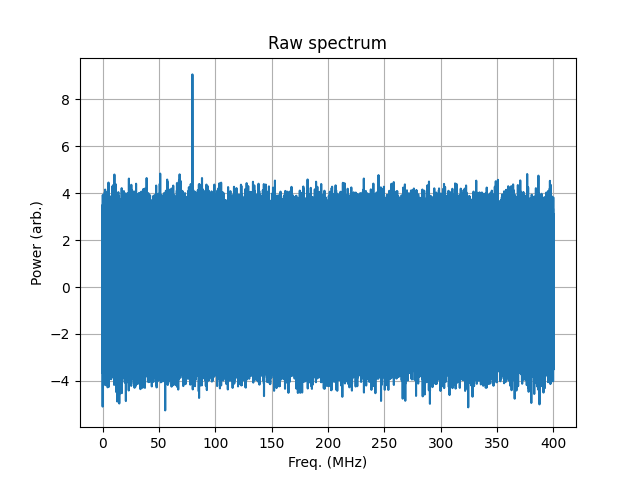

"\nplt.figure()\nplt.title('matched filter spectrum')\nplt.plot(outputFreqs, outputConv)\nplt.xlabel('Freq. (MHz)')\nplt.ylabel('Power (arb.)')\nplt.grid(1)\nplt.show()"

In [66]:
def gen_nu_steps(freqs, startFreq, stopFreq, percent):
    freq    = startFreq
    nuStepList  = []
    while freq < stopFreq:
        #if freq > freqs:
        #    nu0Arr.append(400)
        nuStepList.append(freq)
        endFreq = freq + freq*percent/100
        freq = endFreq
    nuStepList.append(stopFreq) 
    return nuStepList

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))

def setLim(freqs, 
    spec,
    CL,
    nSig = None):
    """
    Set a limit on an array of arrays and return a single frequency limit array and how many "n"-sigma the limit is
    
    Args:
        freqs (np array): Array of sub arrays containing frequency steps 
            at the final analysis frequency bins (i.e. 49-301MHz)  
        spec (np array): Array of sub arrays contaning normilized, normally distributed spectra
        CL (float): Optional. Confidence limit. eg 0.95 for 95% confidence no samples are above threshold 
        nSig (float): Optional if CL not given. dimentionless "n" from n-sigma limit. 
            If not given, calculated automatically given freq array
        
    Returns:
        limit (np array): Single n-sigma limit array where n is calculated using
            the number of frequency bins in frequency OR given as nSig parameter
        nSig (float): dimentionless n from n-sigma limit. 
        
    """
    if isinstance(freqs, list):
        print('asdf')
    #numBins = 
    CL = 0.95 #confidence limit
    #if nSig == None:
    #    scipy.special.erfinv(1-(2*(1-CL)/nBins))*np.sqrt(2)



#test data
freqs       = np.linspace(0,400,2**23)
nu0         = 79.72012
p0          = 22
lamOut      = lam(freqs, nu0, p0, nBins=None, offset=-0e-6)
lamArr      = lamOut[1]


#chirp spec
#np.random.seed(0)  # for reproducibility
frequency = np.linspace(0, 400, 2**23)  # frequency range
undulation = spsig.chirp(frequency, 1/800, frequency[-1], 1/.1) + 100
noise = np.random.normal(10, .01, frequency.shape)  # Gaussian noise
#noise[2**20:2**20+10] = 10.05
#spec = (undulation * noise + lamArr)  # noisy spectrum

#normal noise
spec = np.random.normal(0,1,len(freqs)) + lamArr



#search parameters
startFreq   = 45
stopFreq    = 305
percent     = 5
overlap     = 100 #bins

def mateched_filt(freqs, 
    spec
):
    nuStepList  = gen_nu_steps(freqs, startFreq, stopFreq, percent)
    outputConv  = []
    outputFreqs = []
    #change template over frequency range
    for i, nu in enumerate(nuStepList[0:-1]):
        idxStart        = freq2idx(nuStepList[i], freqs) - overlap
        nu0             = nuStepList[i] + (nuStepList[i+1] - nuStepList[i])/2
        if nuStepList[i+1] == stopFreq:
            idxStop     = freq2idx(nuStepList[i+1], freqs) - 10
        else:
            idxStop     = freq2idx(nuStepList[i+1], freqs) + overlap
        lamOut      = lam(freqs, nu0, p0=1, nBins=100)
        subConv     = np.convolve(np.flip(lamOut[1]), spec[idxStart:idxStop], mode='same')[overlap:-overlap]
        subFreqs    = freqs[idxStart+overlap:idxStop-overlap]
        
        outputConv.append(subConv)
        outputFreqs.append(subFreqs)
    return (outputFreqs, outputConv)


outputFreqs, outputConv = mateched_filt(freqs, spec)



plt.close('all')

plt.figure()
plt.title('Raw spectrum')
plt.plot(freqs, spec)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (arb.)')
plt.grid(1)
plt.show()
'''
plt.figure()
plt.title('matched filter spectrum')
plt.plot(outputFreqs, outputConv)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (arb.)')
plt.grid(1)
plt.show()'''




2.1280452341849863
5.62696999612507


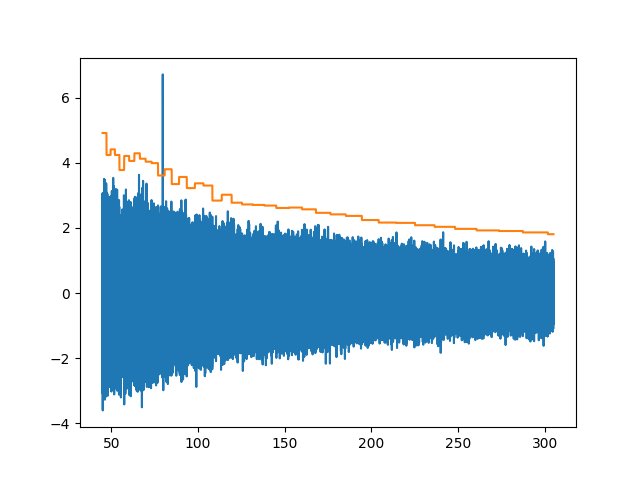

In [67]:
def get_required_sigma(num_draws, desired_confidence):
  # tells you what sigma you would have to go out to in order to have
  # desired_confidence that none of your num_draws will be above that sigma
  desired_confidence = 1-desired_confidence
  def probability_greater_than(sigma):
    return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

  def binomial(N, num_successes, prob_of_success):
    return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

  def probability_none_above(num_draws, sigma):
    # returns probability that after num_draws of draws from a normal distribution
    # that none of the draws will be above the sigma upper limit (mean+sigma)
    return 1-binomial(num_draws, num_draws, 1-probability_greater_than(sigma))

  guess     = scipy.special.erfinv(1-(2*(desired_confidence)/num_draws))*np.sqrt(2) #from taylor expantion
  print(guess)
  nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(num_draws, sigma)-desired_confidence, guess, full_output=True)
  nSig = nSig[0]
  if itr != 1:
    print('fSolve in get_required_sigma failed. Using guess')
    print(msg)
    nSig = guess
  
  return nSig

def set_lim(freqs, spec, CL):
    # If the inputs are 1-D arrays, wrap them in a list to make them an array of arrays
    if isinstance(spec, (np.ndarray, list)) and not isinstance(spec[0], (np.ndarray, list)):
        freqs   = [freqs]
        spec    = [spec]
    nSamps = len(np.hstack(freqs))
    nSig = get_required_sigma(nSamps, CL)

    limits = []
    for idx in range(len(spec)):
        limits.append(nSig * 1.4826 * scipy.stats.median_abs_deviation(spec[idx]))

    limit   = np.concatenate([np.repeat(limit, len(freqs)) for limit, freqs in zip(limits, freqs)])
    freqs   = np.hstack(freqs)
    spec    = np.hstack(spec)
    return (freqs, spec, limit)

    #limit   = np.hstack(limit)



    # Now you can iterate over the outer array
    #for subConv, subFreqs in zip(conv, freqs):
        # Your code to process each pair of subConv and subFreqs
        # ...

    # Continue processing or return results as needed
    print(len(freqs))
    print(freqs)


testFreqs   = np.asarray([1,2,3])
testSpec    = np.asarray([5,6,7])

CL = 0.95
set_lim(testFreqs, testSpec, CL)
freqs, spec, limit = set_lim(outputFreqs, outputConv, CL)

plt.figure()
plt.plot(freqs, spec)
plt.plot(freqs, limit)


In [ ]:
#get data
#real data
spectrum = np.load('/drBiggerBoy/run1p4/plottingSpec/chB_avg_W_switch0.npy')[1:]
spectrum[2**22:2**22+10] *= 1
frequency = np.linspace(0,400,2**23)

freqStart       = 45
freqStop        = 301
idxStart        = freq2idx(freqStart, frequency)
idxStop         = freq2idx(freqStop, frequency)

#test data
testDataFlag = 0
if testDataFlag:
    if 1:
        frequency   = outputFreqs
        spectrum    = outputConv
    if 0:
        np.random.seed(0)  # for reproducibility
        frequency = np.linspace(0, 400, 2**23)  # frequency range

        freqStart       = .5
        freqStop        = 9.5
        idxStart        = freq2idx(freqStart, frequency)
        idxStop         = freq2idx(freqStop, frequency)

        undulation = 10*np.sin(frequency * 100) + frequency*10 +100 # sinusoidal signal
        noise = np.random.normal(10, .01, frequency.shape)  # Gaussian noise
        noise[2**20:2**20+6] = 11.2
        spectrum = (undulation * noise)  # noisy spectrum

    if 0:
        #chirp    
        np.random.seed(0)  # for reproducibility
        frequency = np.linspace(0, 400, 2**23)  # frequency range
        undulation = spsig.chirp(frequency, 1/800, frequency[idxStop], 1/.1) + 100
        noise = np.random.normal(10, .01, frequency.shape)  # Gaussian noise
        noise[2**20:2**20+10] = 10.05
        spectrum = (undulation * noise)  # noisy spectrum

    if 0: #bode plot test
        np.random.seed(0)  # for reproducibility
        frequency = np.linspace(0, 2**23, 2**23)  # frequency range
        spectrum = spsig.chirp(frequency, 1/100000, frequency[-1], 1)


plt.figure()
plt.plot(frequency, spectrum)
plt.show()


In [ ]:
#low pass and divide by "fit"
plt.close('all')
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.stats


def normalize_spectrum(spectrum):
    """
    Function to normalize a spectrum by its mean
    """
    # Low-pass filter design
    cutoff = 40000  # choose a suitable cutoff frequency
    nyq = 0.5 * len(spectrum)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(1, normal_cutoff, btype='low', analog=False)
    
    # Apply the low-pass filter
    spectrum_filtered = filtfilt(b, a, spectrum)

    # Normalize the spectrum by the mean of the filtered spectrum
    normalized_spectrum = spectrum / (spectrum_filtered)

    return normalized_spectrum, spectrum_filtered

# Normalize the test spectrum
normalized_spectrum, spectrum_filtered = normalize_spectrum(spectrum)

normalized_spectrum_analysis = normalized_spectrum[idxStart:idxStop]
spectrum_filtered_analysis  = spectrum_filtered[idxStart:idxStop]
freqs_analysis              = frequency[idxStart:idxStop]

print(f"norm spec mean {np.mean(normalized_spectrum_analysis)}")
print(f"norm spec std {np.std(normalized_spectrum_analysis)}")



In [ ]:
#median filter and divide by "fit"

import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp

def normalize_spectrum(spectrum):
    """
    Function to normalize a spectrum by its mean
    """
    # Low-pass filter design
    spectrumGpu = cp.array(spectrum)


    medFiltSpecGpu = cpim.median_filter(
        spectrumGpu,
        size=(50),
        origin=0
    )
    spectrum_filtered = medFiltSpecGpu.get()
    
    
    # Low-pass filter design
    cutoff = 40000  # choose a suitable cutoff frequency
    nyq = 0.5 * len(spectrum_filtered)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(6, normal_cutoff, btype='low', analog=False)
    
    if 1:
        # Apply the low-pass filter
        spectrum_filtered = filtfilt(b, a, spectrum_filtered)
    

    # Normalize the spectrum by the mean of the filtered spectrum
    normalized_spectrum = spectrum  /spectrum_filtered

    return normalized_spectrum, spectrum_filtered


# Normalize the test spectrum
normalized_spectrum, spectrum_filtered = normalize_spectrum(spectrum)

normalized_spectrum_analysis = normalized_spectrum[idxStart:idxStop]
spectrum_filtered_analysis  = spectrum_filtered[idxStart:idxStop]
freqs_analysis              = frequency[idxStart:idxStop]

print(f"norm spec mean {np.mean(normalized_spectrum_analysis)}")
print(f"norm spec std {np.std(normalized_spectrum_analysis)}")
print(scipy.stats.normaltest(normalized_spectrum_analysis))
print(scipy.stats.normaltest(noise))

In [ ]:
#SG filter and divide by "fit"

import scipy.signal as spsig

def normalize_spectrum(spectrum):
    """
    Function to normalize a spectrum by its mean
    """

    spectrum_filtered = spectrum
    if 1: #median filter
        spectrumGpu = cp.array(spectrum)
        medFiltSpecGpu = cpim.median_filter(
            spectrumGpu,
            size=(50),
            origin=0
        )
        spectrum_filtered = medFiltSpecGpu.get()
    if 1:
        # SG filter
        spectrum_filtered = spsig.savgol_filter(
            spectrum_filtered,
            window_length=(51),
            polyorder=1
        )
    
    if 0:
        # Low-pass filter design
        cutoff = 40000  # choose a suitable cutoff frequency
        nyq = 0.5 * len(spectrum_filtered)  # Nyquist frequency
        normal_cutoff = cutoff / nyq
        b, a = butter(4, normal_cutoff, btype='low', analog=False)
        
        # Apply the low-pass filter
        spectrum_filtered = filtfilt(b, a, spectrum_filtered)
    

    # Normalize the spectrum by the mean of the filtered spectrum
    normalized_spectrum = spectrum  /spectrum_filtered

    return normalized_spectrum, spectrum_filtered


# Normalize the test spectrum
normalized_spectrum, spectrum_filtered = normalize_spectrum(spectrum)

normalized_spectrum_analysis = normalized_spectrum[idxStart:idxStop]
spectrum_filtered_analysis  = spectrum_filtered[idxStart:idxStop]
freqs_analysis              = frequency[idxStart:idxStop]

print(f"norm spec mean {np.mean(normalized_spectrum_analysis)}")
print(f"norm spec std {np.std(normalized_spectrum_analysis)}")
print(scipy.stats.normaltest(normalized_spectrum_analysis))
print(scipy.stats.normaltest(noise))

In [ ]:
plt.close('all')
if 1:
    # Plot the test spectrum
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.plot(frequency, spectrum, label='Original spectrum')
    plt.plot(freqs_analysis, spectrum_filtered_analysis, label='filtered spectrum', color='red')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('Test Spectrum')
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.show()

if testDataFlag and 0:
    # plot undulation (H) vs filtered <H>
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_analysis, 10*undulation[idxStart:idxStop] - spectrum_filtered_analysis, label='<H>', color='blue')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('H - <H> diff')
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.show()

if testDataFlag and 0:
    # plot undulation (H) vs filtered <H>
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_analysis, 10*undulation[idxStart:idxStop], label='H', color='blue')
    plt.plot(freqs_analysis, spectrum_filtered_analysis, label='<H>', color='red')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('H and <H>')
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.show()


if 1:
    # Normalized Spectrum
    nSigma = 5
    oneSigMad = 1.4826*scipy.stats.median_abs_deviation(normalized_spectrum_analysis)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs_analysis, (normalized_spectrum_analysis-1)/oneSigMad, label='Normalized spectrum')
    plt.plot((freqs_analysis[0], freqs_analysis[-1]), (nSigma, nSigma), label = f'{nSigma} Sigma Limit')
    plt.xlabel('Frequency')
    plt.ylabel('Normalized Power')
    plt.title('Normalized Spectrum')
    plt.grid(True)
    plt.legend(loc = 'lower left')
    plt.show()

if testDataFlag and 0:
    # Z score, noise vs norm
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_analysis, scipy.stats.zscore(normalized_spectrum_analysis), label='Normalized spectrum', color='blue')
    plt.plot(frequency, scipy.stats.zscore(noise), label='Noise', color='red', alpha = 0.5)
    plt.xlabel('Frequency')
    plt.ylabel('Normalized Power')
    plt.title('Z score, noise vs norm')
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.show()

if testDataFlag and 0:
    # Plot the z score diff spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_analysis, scipy.stats.zscore(normalized_spectrum_analysis) - scipy.stats.zscore(noise)[idxStart:idxStop], label='Normalized spectrum', color='blue')
    plt.xlabel('Frequency')
    plt.ylabel('Normalized Power')
    plt.title('Z score diff')
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.show()

if 0:
    # Plot the 5 sigma limit
    plt.figure(figsize=(10, 5))
    plt.plot(frequency, spectrum, label='Spectrum', color='blue')
    plt.plot(freqs_analysis, (1+1.4826*5*scipy.stats.median_abs_deviation(normalized_spectrum_analysis))*spectrum_filtered_analysis, label='limit', color='red')
    plt.xlabel('Frequency')
    plt.ylabel('Normalized Power')
    plt.title('Spec and 5 sigma limit')
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.show()

if 0:

    # calculate common bin edges
    min_bin_edge = min(np.min(scipy.stats.zscore(normalized_spectrum_analysis)), np.min(scipy.stats.zscore(noise[idxStart:idxStop])))
    max_bin_edge = max(np.max(scipy.stats.zscore(normalized_spectrum_analysis)), np.max(scipy.stats.zscore(noise[idxStart:idxStop])))

    bin_edges = np.linspace(min_bin_edge, max_bin_edge, 500)  # this creates 50 bins

    # plot histograms
    plt.figure(figsize=(10, 5))
    plt.title('Z score')
    plt.hist(scipy.stats.zscore(normalized_spectrum_analysis), bins=bin_edges, label='Normalized Spectrum')
    plt.hist(scipy.stats.zscore(noise[idxStart:idxStop]), bins=bin_edges, alpha=0.5, label='Original Noise')
    plt.legend(loc='upper left')
    plt.semilogy()
print(len(normalized_spectrum_analysis))
print(len(noise[idxStart:idxStop]))

In [ ]:
#Generate a fake background
numPoints               = 2**18
freqs                   = np.linspace(0, 400, numPoints)

demoSpec                = np.random.normal(10, 1, numPoints)
demoSpec[numPoints//2]  *= 2
demoSpec                *= np.sin(1-freqs/900)


plt.close('all')
plt.plot(freqs, demoSpec)

plt.figure()
plt.plot(freqs, demoSpec/np.sin(1-freqs/900))


In [ ]:
import numpy as np

class AnalysisPipeline:
    """
    A class to perform a dark photon search on an averaged spectrum

    Attributes
    ----------
    spec            : arr
        Power spectrum to search for dark photon signal
    freqs           : arr
        Array of frequenies that corosponds to spec
    analysisSpec    : arr
        Spectrum that is being worked on

    Methods
    -------
    high_pass_filter(fcNumBins=int,
        order=int):
        Pre-filters the spectrum to remove DC offset and large scale undulations

    optimal_filter(
        ):
        Performs a convolution of the input against a template array
        Calls gen_template

    gen_template(
        ):
        Generates a template function array
    
    rolling_STD(window=int,
        filt=bool,
        fcNumBins=int,
        order=int,
        numProc=int (opt.),
        mode=str
        ):
        Calculates rolling 1 STD threshold using an optional function

    find_candidates(CL=float,
        ):
        Calculates a threshold such that there is a (1-CL)% chance
        that a bin is above that threshold.
    """
    def __init__(self,
        spec, 
        freqs
        ):

        self.spec = spec
        self.freqs = freqs
        self.analysisSpec = np.zeros(spec)

    def high_pass_filter(self):
        '''
        Performs basic buttersworth filtering of a spectrum.
            Parameters:
                fcNumBins (int) : Corner "frequency" in bins
                order (int)     : Order of filter
        '''
        pass

    def optimal_filter(self):
        """
        Implement optimal filtering/convolution here
        """
        pass

    def rolling_STD(self):
        '''
        Computes a rolling STD on the input spectrum. 
            Parameters:
                window (int)    : length of window to compute rolling function on
                filt (bool)     : should the output be filtered. 1 = yes
                fcNumBins (int) : if filt, corner "frequency" (in bins)
                order (int)     : if filt, order of filter
                mode (str)      : how to handle edges
                                'nan pad'
                                    preserve length of input array. Pad ends with nands
                numProc (int)   : number of processers to use
                
        '''
        pass

    def calculate_threshold(self):
        """
        Implement threshold calculation here
        """
        pass

    def run_analysis(self):
        self.high_pass_filter()
        self.optimal_filter()
        self.calculate_rolling_mad()
        self.calculate_threshold()


######## Call this from notebook ########
# Instantiate the analysis pipeline
#analysis = AnalysisPipeline(spectrum, window_size, step_size, num_processes)

# Run the full analysis
#analysis.run_analysis()

In [ ]:
class avgSpecAnalysis:
    '''
    This class takes in an average spectrum and returns a list of candidates.
    There should be some code that runs before this that unpacks the saved data 
    structure and averages together some or all spectra. 
    If candidates are found, it is up to a future analysis to inspect time dependance.
    ####INPUTS####
    freqs: array like
        frequency array
    avgSpec: array like
        Single "master spectrum". All time dependance has been averaged out.

    '''
    def __init__(self,
    freqs,
    avgSpec,

    ):
        self.avgSpec        = avgSpec
        self.freqs          = freqs

    def mad_np(arr
    ):
        median = np.median(arr)
        return np.median(np.abs(arr-median))

    def freq2Idx(self,
        freq, 
        freqsAll
    ):
        return int(freq/freqsAll[-1] * len(freqsAll))

    def idx2freq(self,
        idx,
        freqs
    ):
        return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]
    
    def rollingMadLim(self,
        nSigma      = 1,
        window      = 1
    ):

        rollingMadArr = dr.rolling(self.specFiltered, window, 1, self.mad_np, numProc=48)

        filter_fc           = 30 * window
        filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
        diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
        rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
        return rollMadLim, specFiltered, nSigma, order, fc_numBins

    def HPF_filter(self,
        order       = 1,
        fc_numBins  = 100,
    ):
        self.specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)


In [ ]:
analysis =  avgSpecAnalysis(freqs,
    demoSpec)

rollingMadLim = analysis.rollingMadLim()

In [ ]:
plt.close('all')
plt.figure()
plt.plot(freqs, 5*rollingMadLim[0])
plt.plot(freqs, rollingMadLim[1])

In [ ]:
specFiltered = dr.filterSpec(demoSpec, fc_numBins=100, order=1)
plt.close('all')
plt.figure()
plt.plot(freqs, specFiltered)